<a href="https://colab.research.google.com/github/Nuthan03/Transfer_Learning/blob/main/Scaling_up.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Transfer Learning with TensorFlow Part 3: Scaling up(Food Vision mini)

We have seen the power of transfer learning feature extraction and fine--tuning, now it's time to scale up to all the classes in Food101(101 total classes of food)

Our goal is to beat the original Food101 paper with 10% of the training.

In [1]:
# Check to see if we are using a GPU
!nvidia-smi

Thu Dec  7 05:39:41 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   61C    P8    11W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Creating a helper function

In previous notebooks, we have created a series of helper function to do different tasks, let's download them.

In [2]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2023-12-07 05:39:41--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2023-12-07 05:39:41 (86.8 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [3]:
# Import series of helper function for our notebook
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, compare_historys, walk_through_dir

## 101 Food Classes: working with less data

The data we are downloading comes from the original Food101
dataset but has been preprocessed using the image_data_modification notebook

In [4]:
# Download data from Google Storage (already preformatted)
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip

unzip_data("101_food_classes_10_percent.zip")

train_dir = "101_food_classes_10_percent/train/"
test_dir = "101_food_classes_10_percent/test/"

--2023-12-07 05:39:50--  https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 209.85.234.207, 142.251.171.207, 108.177.112.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|209.85.234.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1625420029 (1.5G) [application/zip]
Saving to: ‘101_food_classes_10_percent.zip’

101_food_classes_10 100%[===================>]   1.51G   230MB/s    in 9.1s    

2023-12-07 05:40:00 (170 MB/s) - ‘101_food_classes_10_percent.zip’ saved [1625420029/1625420029]



In [5]:
# How many images/classes are there
walk_through_dir("101_food_classes_10_percent")

There are 2 directories and 0 images in '101_food_classes_10_percent'.
There are 101 directories and 0 images in '101_food_classes_10_percent/test'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/prime_rib'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/french_fries'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/onion_rings'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/club_sandwich'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/fish_and_chips'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/mussels'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/carrot_cake'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/bibimbap'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/baklava'.
There are 0 directories and 250 images in '101_f

In [6]:
# Setup data inputs
import tensorflow as tf
IMG_SIZE = (224, 224)
train_data_all_10_percent = tf.keras.preprocessing.image_dataset_from_directory(train_dir,
                                                                               label_mode= "categorical",
                                                                               image_size=IMG_SIZE)

test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                label_mode="categorical",
                                                                image_size=IMG_SIZE,
                                                                shuffle=False) # Dont shuffle test data for prediction analysis

Found 7575 files belonging to 101 classes.
Found 25250 files belonging to 101 classes.


## Train a big dog model with transfer learning on 10% of 101 food classes

Here are the steps we are going to take:
* Create a ModelCheckpoint callback
* Create a data augmentation layer to build data augmentation right into the model
* Build a headless(no top layers)Functional EfficientNetBO backboned-mdoel
* Compile our model
* Feature extract for 5 full passes

In [7]:
# Create checkpoint callback
checkpoint_path = "101_classes_10_percent_data_model_checkpoint"
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                     save_weights_only=True,
                                                     monitor="val_accuracy",
                                                     save_best_only=True)

In [8]:
# Create data augmentation layer to incorperate it right into the model
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

# Setting up data augmentation
data_augmentation = Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2),
    layers.RandomHeight(0.2),
    layers.RandomWidth(0.2),
    # preprocessing.Rescaling(1./255) # keep for ResNet50V2, remove for EfficientNetBO
], name ="data_augmentation")

In [9]:
# Setup the base model and freeze its layers (this will extract features)
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

# Setup model architecture with trainable top layers
inputs = layers.Input(shape=(224, 224, 3), name="input_layer") #Shape of input image
x = data_augmentation(inputs)
x = base_model(x, training=False)
x = layers.GlobalAveragePooling2D(name="global_average_pooling")(x) # pool the outputs of the base model
outputs = layers.Dense(len(train_data_all_10_percent.class_names), activation="softmax", name="output_layer")(x)
model = tf.keras.Model(inputs, outputs)

16705208/16705208 [==============================] - 0s 0us/step


In [10]:
# Get a summary of model we have created
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation (Sequent  (None, None, None, 3)     0         
 ial)                                                            
                                                                 
 efficientnetb0 (Functional  (None, None, None, 1280   4049571   
 )                           )                                   
                                                                 
 global_average_pooling (Gl  (None, 1280)              0         
 obalAveragePooling2D)                                           
                                                                 
 output_layer (Dense)        (None, 101)               129381    
                                                             

In [11]:
# Compile
model.compile(loss="categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])

# Fit
history_all_classes_10_percent = model.fit(train_data_all_10_percent,
                                           epochs=5,
                                           validation_data=test_data,
                                           validation_steps=int(0.15 * len(test_data)),
                                           callbacks=[checkpoint_callback])

Epoch 1/5
237/237 [==============================] - 106s 381ms/step - loss: 3.4006 - accuracy: 0.2628 - val_loss: 2.4868 - val_accuracy: 0.4550
Epoch 2/5
237/237 [==============================] - 70s 292ms/step - loss: 2.2120 - accuracy: 0.4953 - val_loss: 2.0600 - val_accuracy: 0.5069
Epoch 3/5
237/237 [==============================] - 64s 267ms/step - loss: 1.8189 - accuracy: 0.5686 - val_loss: 1.8765 - val_accuracy: 0.5320
Epoch 4/5
237/237 [==============================] - 57s 238ms/step - loss: 1.6020 - accuracy: 0.6149 - val_loss: 1.8128 - val_accuracy: 0.5318
Epoch 5/5
237/237 [==============================] - 54s 224ms/step - loss: 1.4510 - accuracy: 0.6448 - val_loss: 1.7833 - val_accuracy: 0.5352


In [12]:
# Evaluate on the whole test datasets
fine_tuning_results = model.evaluate(test_data)
fine_tuning_results

790/790 [==============================] - 59s 75ms/step - loss: 1.5851 - accuracy: 0.5840


[1.5850722789764404, 0.5839604139328003]

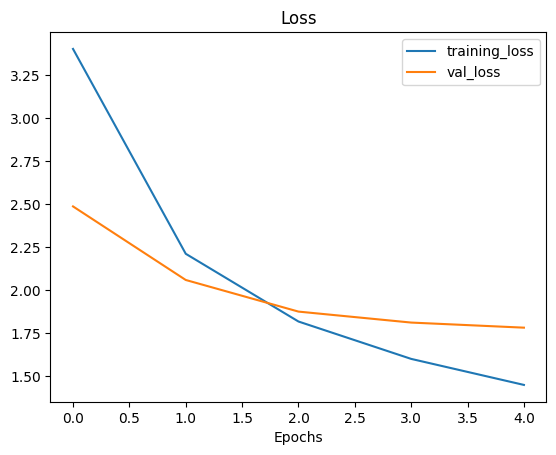

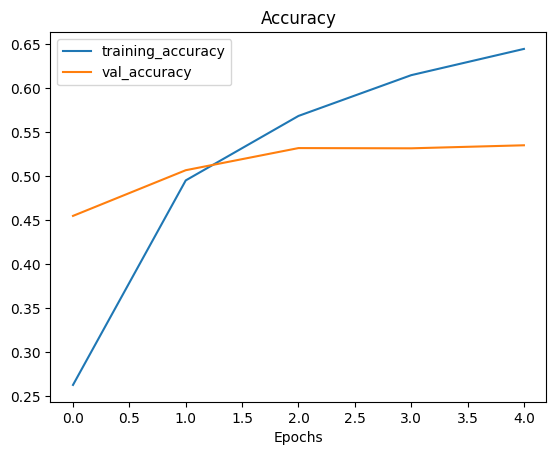

In [13]:
plot_loss_curves(history_all_classes_10_percent)

## Fine-tuning

In [14]:
# Unfreeze all of the layers in the base model
base_model.trainable =True

# Refreeze every layer except the last 5
for layer in base_model.layers[:-5]:
  layer.trainable = False

In [15]:
# Recompile model with lower learning (it's typically best pratice to lower the learning rate when fine-tuning)
model.compile(loss="categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              metrics=["accuracy"])

In [16]:
# What layers in the model are trainable
for layer in model.layers:
  print(layer.name, layer.trainable)

input_layer True
data_augmentation True
efficientnetb0 True
global_average_pooling True
output_layer True


In [17]:
# Check which layers are trainable in our base_model
for layer_number, layer in enumerate(base_model.layers):
  print(layer_number, layer.name, layer.trainable)

0 input_1 False
1 rescaling False
2 normalization False
3 rescaling_1 False
4 stem_conv_pad False
5 stem_conv False
6 stem_bn False
7 stem_activation False
8 block1a_dwconv False
9 block1a_bn False
10 block1a_activation False
11 block1a_se_squeeze False
12 block1a_se_reshape False
13 block1a_se_reduce False
14 block1a_se_expand False
15 block1a_se_excite False
16 block1a_project_conv False
17 block1a_project_bn False
18 block2a_expand_conv False
19 block2a_expand_bn False
20 block2a_expand_activation False
21 block2a_dwconv_pad False
22 block2a_dwconv False
23 block2a_bn False
24 block2a_activation False
25 block2a_se_squeeze False
26 block2a_se_reshape False
27 block2a_se_reduce False
28 block2a_se_expand False
29 block2a_se_excite False
30 block2a_project_conv False
31 block2a_project_bn False
32 block2b_expand_conv False
33 block2b_expand_bn False
34 block2b_expand_activation False
35 block2b_dwconv False
36 block2b_bn False
37 block2b_activation False
38 block2b_se_squeeze False
39

In [18]:
# Fine-tune for 5 more epochs
fine_tune_epochs = 10

history_all_classes_10_percent_fine_tune = model.fit(train_data_all_10_percent,
                                                     epochs=fine_tune_epochs,
                                                     validation_data=test_data,
                                                     validation_steps=int(0.15 * len(test_data)),
                                                     initial_epoch=history_all_classes_10_percent.epoch[-1])

Epoch 5/10
237/237 [==============================] - 63s 228ms/step - loss: 1.2106 - accuracy: 0.6783 - val_loss: 1.7417 - val_accuracy: 0.5432
Epoch 6/10
237/237 [==============================] - 54s 227ms/step - loss: 1.0914 - accuracy: 0.7109 - val_loss: 1.6851 - val_accuracy: 0.5516
Epoch 7/10
237/237 [==============================] - 45s 190ms/step - loss: 1.0230 - accuracy: 0.7212 - val_loss: 1.7187 - val_accuracy: 0.5511
Epoch 8/10
237/237 [==============================] - 45s 188ms/step - loss: 0.9525 - accuracy: 0.7439 - val_loss: 1.7257 - val_accuracy: 0.5493
Epoch 9/10
237/237 [==============================] - 45s 186ms/step - loss: 0.8842 - accuracy: 0.7634 - val_loss: 1.7447 - val_accuracy: 0.5432
Epoch 10/10
237/237 [==============================] - 44s 183ms/step - loss: 0.8336 - accuracy: 0.7780 - val_loss: 1.7324 - val_accuracy: 0.5474


In [19]:
# Evaluate on the whole test data
all_classes_10_percent_fine_tune_results = model.evaluate(test_data)
all_classes_10_percent_fine_tune_results

790/790 [==============================] - 62s 78ms/step - loss: 1.5009 - accuracy: 0.6002


[1.500905990600586, 0.6001980304718018]

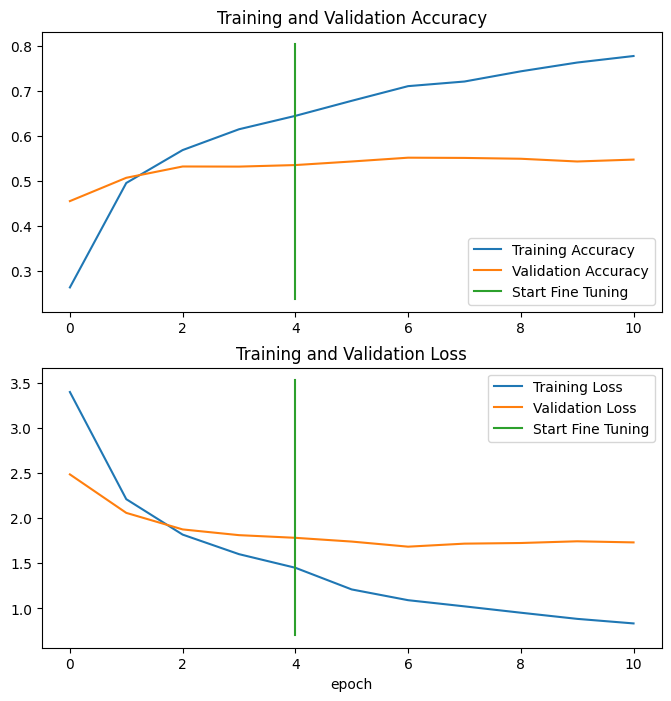

In [20]:
# compare the histories of feature extraction model with fine-tuning model
compare_historys(original_history=history_all_classes_10_percent,
                 new_history=history_all_classes_10_percent_fine_tune,
                 initial_epochs=5)